In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import glob
import json
import pandas as pd
import numpy as np
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn.reporting import get_clusters_table
sys.path.append('..')
from utils.data import load_participant_list, get_betamap_paths

# Parameters

In [3]:
statistic = 'z_score'
multiple_comp_corr = 'fpr'
alpha = 0.05
run = 'test'
first_level_dir = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/rsa_no_iti_20250310'

# First level parameters

In [4]:
# Find the first JSON file
json_file_path = glob.glob(os.path.join(first_level_dir, '**', '*_params.json'), recursive=True)[0]

# Load and print the JSON file contents
with open(json_file_path, 'r') as file:
    json_data = json.load(file)
    for key, value in json_data.items():
        print(f"{key}: {value}")


model_name: rsa_no_iti
tr: 2.33384
hrf_model: spm
noise_model: ar1
smoothing_fwhm: 5
motion_type: basic
include_physio: True
brain_mask: True
fd_thresh: 0.5
std_dvars_thresh: 2
exclusion_threshold: 0.2
scrub: dummies
duration: all
iti_included: False


# Load First level data

In [5]:
base_dir = '/home/ubuntu/data/learning-habits'
sub_ids = load_participant_list(base_dir)

In [6]:
stimuli = [1, 2, 3, 4, 5, 6, 7, 8]

In [8]:
betamap_dict = {}
for stim in stimuli:
    betamap_paths, found_subs = get_betamap_paths(sub_ids, first_level_dir, run, f"sub-{{sub_id}}_run-{{run}}_betamap_first_stim_presentation_{stim}.nii.gz")
    betamap_dict[stim] = betamap_paths
    print(f"Found {len(betamap_paths)} beta maps for stimulus {stim}")

Found 57 beta maps for stimulus 1
Found 57 beta maps for stimulus 2
Found 57 beta maps for stimulus 3
Found 57 beta maps for stimulus 4
Found 57 beta maps for stimulus 5
Found 57 beta maps for stimulus 6
Found 57 beta maps for stimulus 7
Found 57 beta maps for stimulus 8


In [11]:
betamaps_imgs = {stim: [image.load_img(path) for path in paths] for stim, paths in betamap_dict.items()}

# Look at combined stim presentation

In [22]:
all_stim_presentation = [item for value_list in betamaps_imgs.values() for item in value_list]

In [23]:
X_sc = pd.DataFrame([1] * len(all_stim_presentation), columns=['button_press'])

In [24]:
second_level_model_sc = SecondLevelModel().fit(all_stim_presentation, design_matrix=X_sc)

In [25]:
SC_WB_zmap = second_level_model_sc.compute_contrast(output_type=statistic)

In [26]:
SC_WB_thresholded_map, SC_WB_threshold = threshold_stats_img(SC_WB_zmap, alpha=alpha, height_control='bonferroni')#, cluster_threshold=30)
print(f"RL whole brain Bonferroni threshold: {SC_WB_threshold:.3f}")

RL whole brain Bonferroni threshold: 4.957


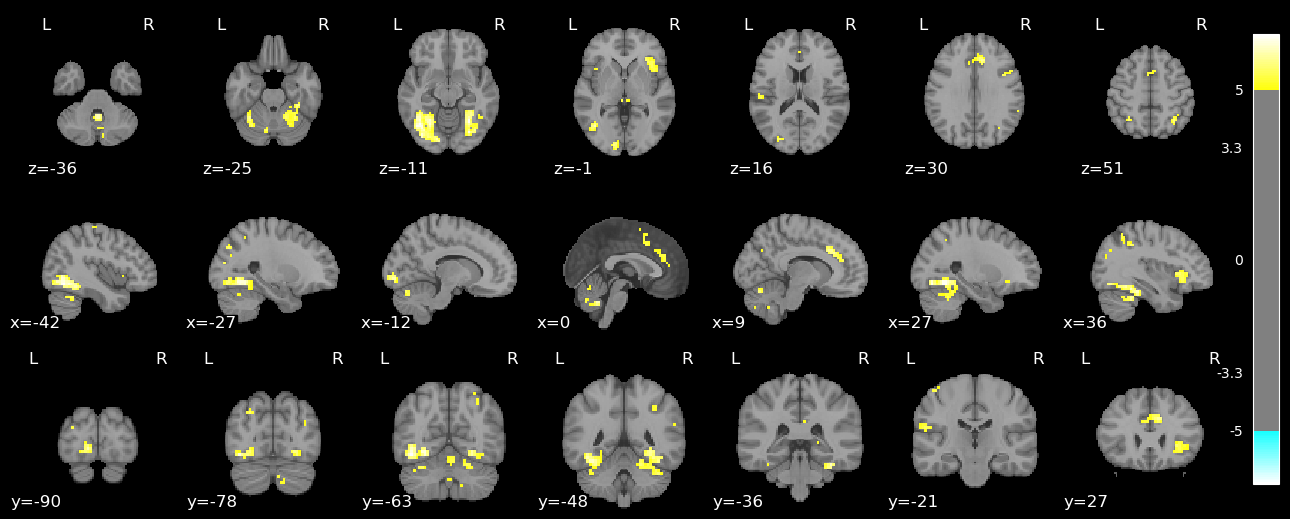

In [28]:
plot_stat_map(SC_WB_zmap, threshold=SC_WB_threshold, black_bg=True, display_mode='mosaic', title='')

## Load masks

In [29]:
mask_dir = '/home/ubuntu/data/learning-habits/masks'
vmpfc_mask_path = os.path.join(mask_dir, 'vmpfc_mask.nii.gz')
striatum_mask_path = os.path.join(mask_dir, 'striatum_mask.nii.gz')
putamen_mask_path = os.path.join(mask_dir, 'putamen_mask.nii.gz')
parietal_mask_path = os.path.join(mask_dir, 'parietal_mask.nii.gz')

# Reward level contrasts

In [55]:
# Stim 8 vs stim 1
images = [betamaps_imgs[7], betamaps_imgs[6], betamaps_imgs[3], betamaps_imgs[2]]
X = pd.DataFrame([1] * 2*len(images[0]) + [0] * 2 * len(images[1]), columns=['stim8_vs_stim1'])

In [58]:
# Flatten the images list
flattened_images = [img for sublist in images for img in sublist]

# Fit the second level model
second_level = SecondLevelModel().fit(flattened_images, design_matrix=X)

In [59]:
WB_zmap = second_level.compute_contrast(output_type=statistic)

## Whole brain

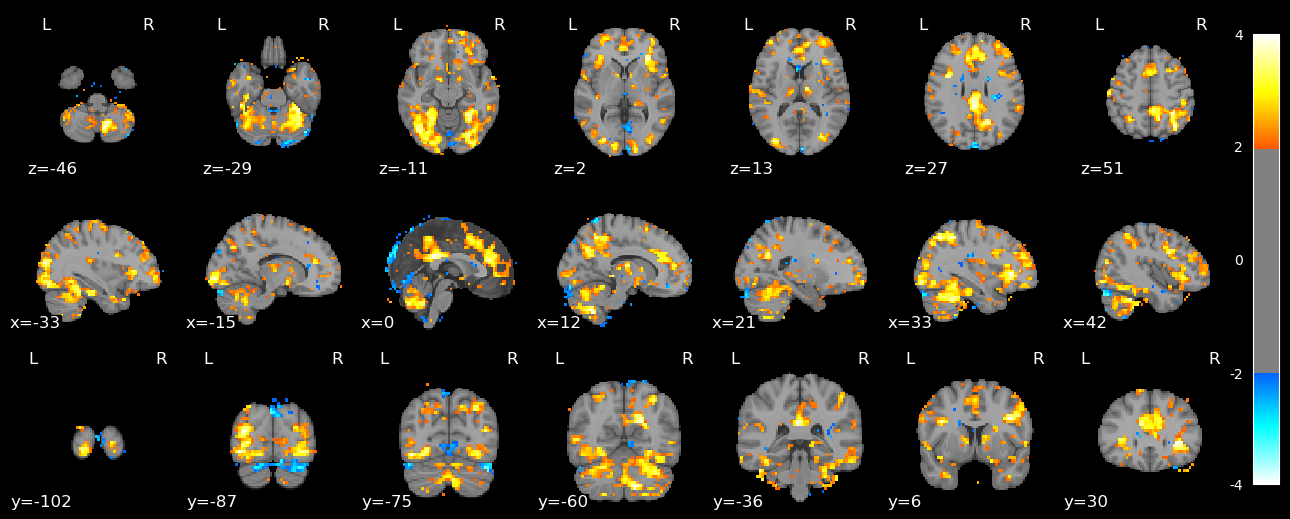

In [60]:
plot_stat_map(WB_zmap,threshold=2, black_bg=True, display_mode='mosaic', title='')

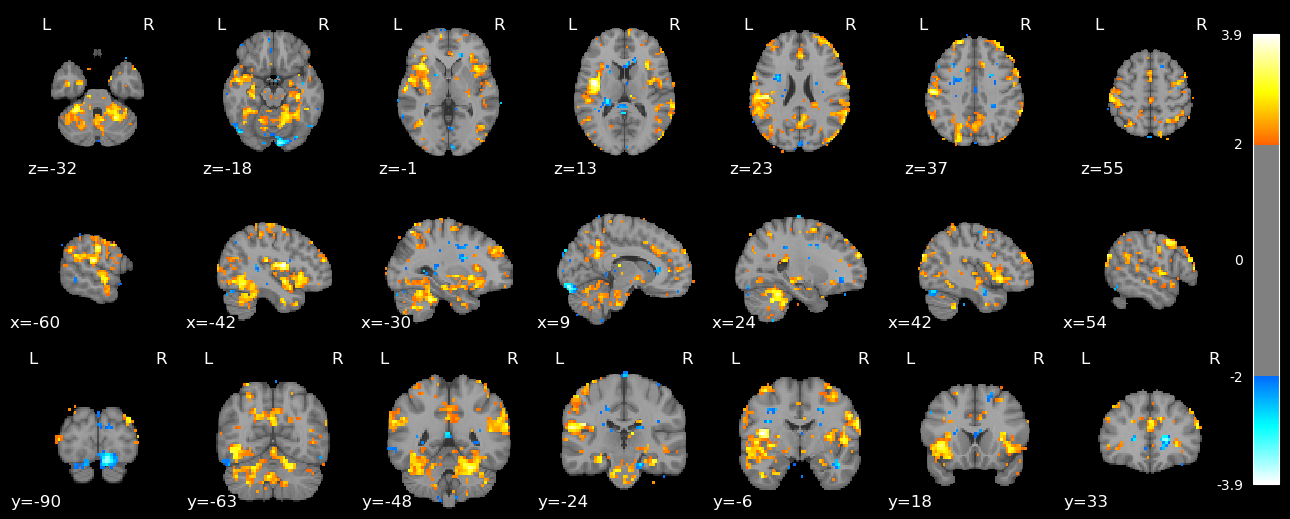

In [ ]:
plot_stat_map(WB_zmap,threshold=2, black_bg=True, display_mode='mosaic', title='')

## ROIs for Q-values: VMPFC

In [61]:
vmpfc_mask = image.load_img(vmpfc_mask_path)
vmpfc_mask = image.resample_to_img(vmpfc_mask, WB_zmap, interpolation='nearest')
vmpfc_masker = NiftiMasker(mask_img=vmpfc_mask)

In [62]:
vmpfc_second_level = SecondLevelModel(mask_img=vmpfc_masker).fit(flattened_images, design_matrix=X)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [63]:
vmpfc_zmap = vmpfc_second_level.compute_contrast(output_type=statistic)

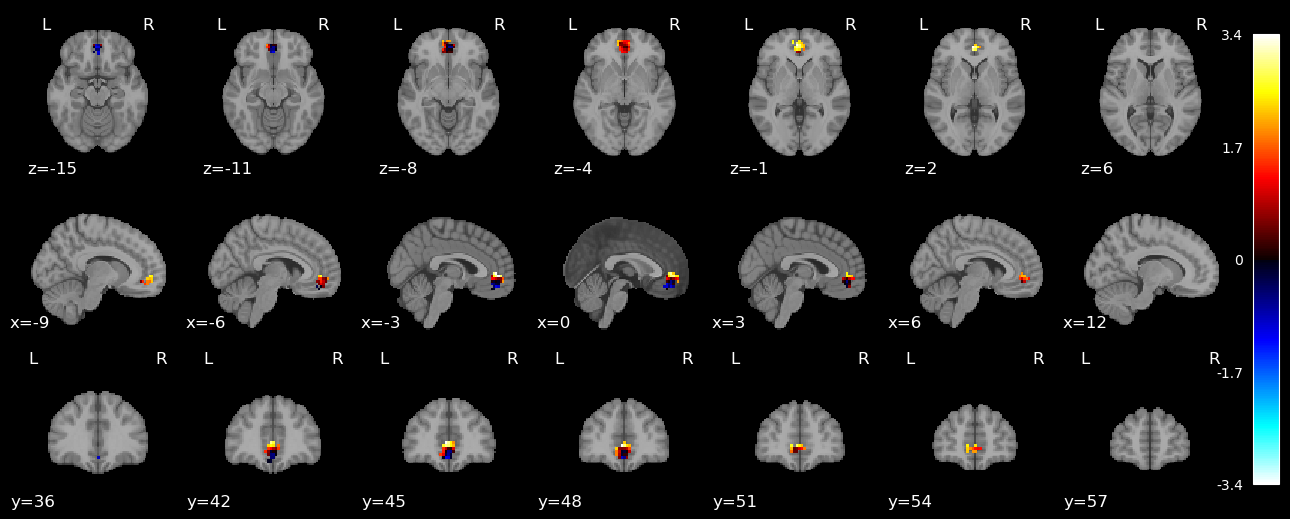

In [64]:
plot_stat_map(vmpfc_zmap, black_bg=True, display_mode='mosaic', title='')

In [65]:
vmpfc_thresholded_zmap, vmpfc_threshold = threshold_stats_img(vmpfc_zmap, alpha=alpha, height_control='fdr')

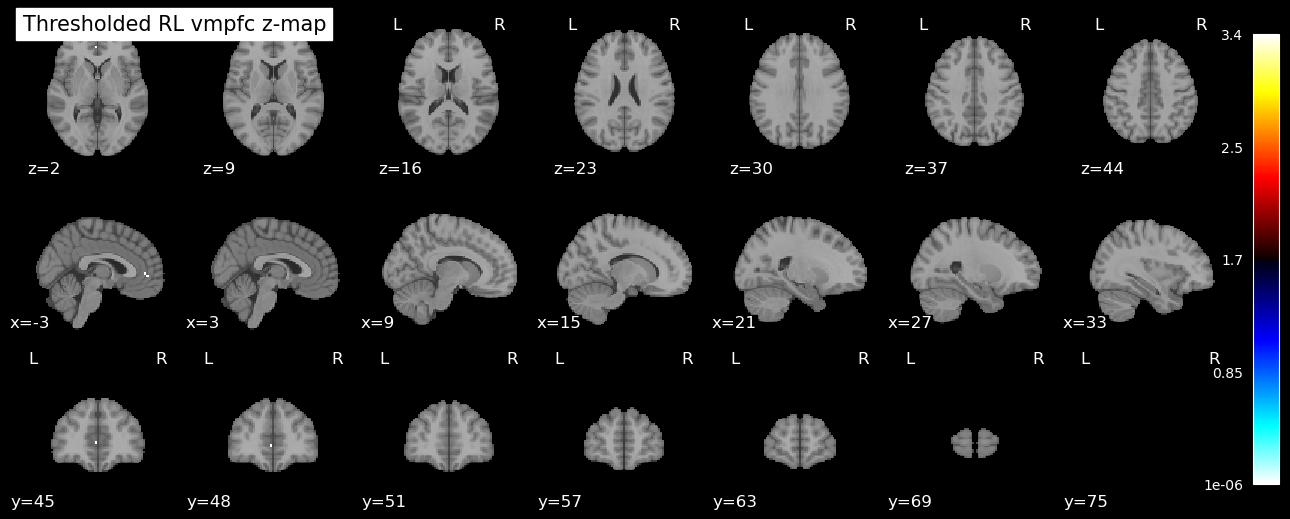

In [66]:
plot_stat_map(vmpfc_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded RL vmpfc z-map')

## ROIs for Q-values: Striatum

In [67]:
striatum_mask = image.load_img(striatum_mask_path)
striatum_mask = image.resample_to_img(striatum_mask, WB_zmap, interpolation='nearest')
striatum_masker = NiftiMasker(mask_img=striatum_mask)

In [68]:
striatum_second_level = SecondLevelModel(mask_img=striatum_masker)
striatum_second_level = striatum_second_level.fit(flattened_images, design_matrix=X)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [69]:
striatum_zmap = striatum_second_level.compute_contrast(output_type=statistic)

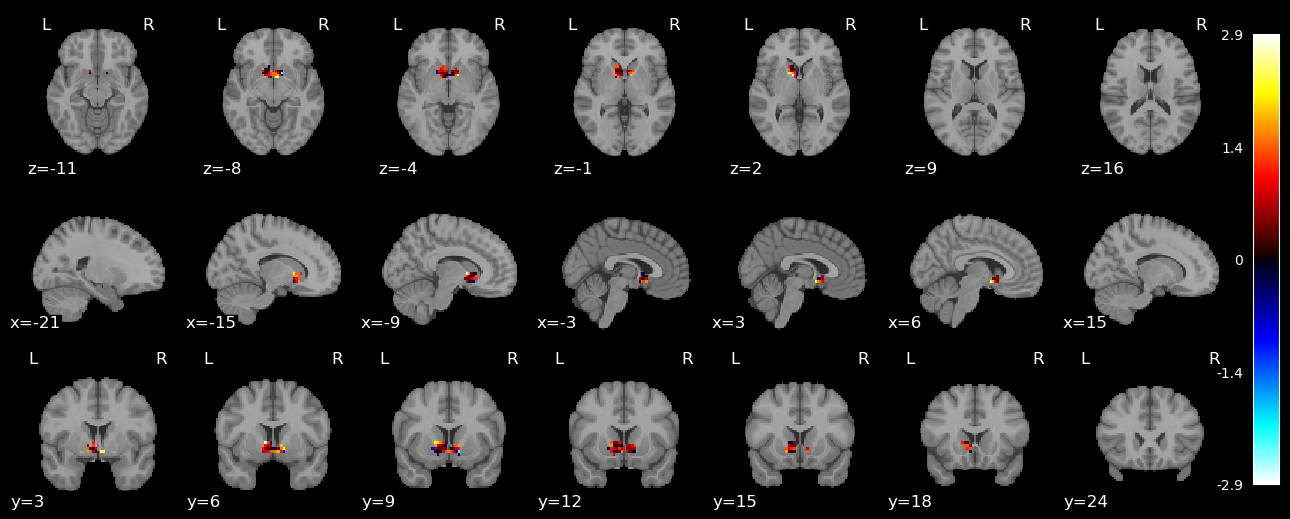

In [70]:
plot_stat_map(striatum_zmap, black_bg=True, display_mode='mosaic', title='')

In [71]:
striatum_thresholded_zmap, striatum_threshold = threshold_stats_img(striatum_zmap, alpha=alpha, height_control='fdr')

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 2.8529247791333745. But, you have given threshold=inf.
  stat_img = threshold_img(


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


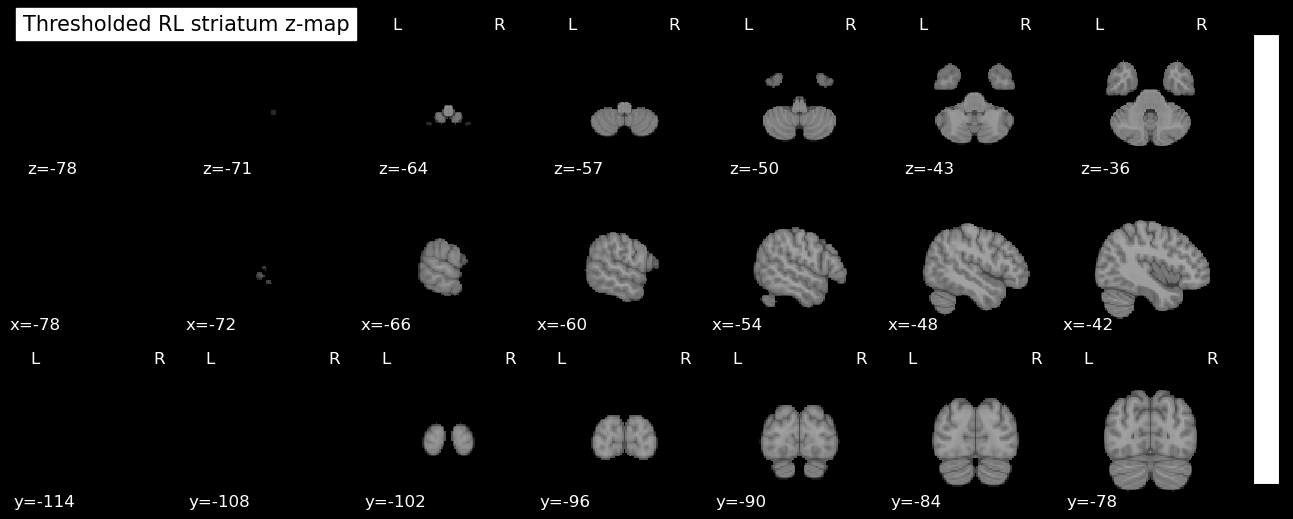

In [72]:
plot_stat_map(striatum_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded RL striatum z-map')